In [13]:
# Part 0: Shared config & imports (run this first)
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pprint import pprint

RANDOM_STATE = 42
CSV_PATH = "diabetes_binary_health_indicators_BRFSS2015.csv"
OUTPUT_DIR = "model_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# convenience: display full dataframe columns when needed
pd.set_option("display.max_columns", None)
print("Config ready. CSV_PATH:", CSV_PATH)

Config ready. CSV_PATH: diabetes_binary_health_indicators_BRFSS2015.csv


In [14]:
# Part 1: Load & dtype optimization
def load_and_optimize_dtypes(csv_path: str, use_sample=False, sample_frac=0.25):
    df = pd.read_csv(csv_path)
    if use_sample:
        df = df.sample(frac=sample_frac, random_state=RANDOM_STATE).reset_index(drop=True)

    # Example dtype downcasts (adjust to match your dataset columns)
    binary_cols = [
        "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "HeartDiseaseorAttack",
        "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare",
        "NoDocbcCost", "DiffWalk", "Sex"
    ]
    for c in binary_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], downcast="unsigned")

    if "BMI" in df.columns:
        df["BMI"] = pd.to_numeric(df["BMI"], downcast="float")
    for c in ["MentHlth", "PhysHlth", "GenHlth", "Age", "Education", "Income"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], downcast="unsigned")

    if "Diabetes_binary" in df.columns:
        df["Diabetes_binary"] = pd.to_numeric(df["Diabetes_binary"], downcast="unsigned")

    return df

df = load_and_optimize_dtypes(CSV_PATH, use_sample=False)
print("Loaded dataframe shape:", df.shape)
print("\nDtype summary (sample):")
print(df.dtypes.value_counts())
print("\nFirst 5 rows:")
display(df.head())


Loaded dataframe shape: (253680, 22)

Dtype summary (sample):
uint8      21
float32     1
Name: count, dtype: int64

First 5 rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4


In [15]:
# Part 2: Quick EDA
target_col = "Diabetes_binary"
assert target_col in df.columns, f"Target '{target_col}' not found."

print("Target distribution:")
print(df[target_col].value_counts(dropna=False))
print("\nTarget percentage positive:")
print(df[target_col].mean() * 100)

print("\nMissing values per column (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

# A few summary stats for numeric columns
num_cols = ["BMI", "MentHlth", "PhysHlth", "GenHlth", "Age"]
num_cols = [c for c in num_cols if c in df.columns]
if num_cols:
    print("\nNumeric summary:")
    display(df[num_cols].describe().T)
else:
    print("\nNo numeric columns from the expected list were found.")


Target distribution:
Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

Target percentage positive:
13.933301797540206

Missing values per column (top 20):
Diabetes_binary         0
HighBP                  0
Education               0
Age                     0
Sex                     0
DiffWalk                0
PhysHlth                0
MentHlth                0
GenHlth                 0
NoDocbcCost             0
AnyHealthcare           0
HvyAlcoholConsump       0
Veggies                 0
Fruits                  0
PhysActivity            0
HeartDiseaseorAttack    0
Stroke                  0
Smoker                  0
BMI                     0
CholCheck               0
dtype: int64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
BMI,253680.0,28.382364,6.607666,12.0,24.0,27.0,31.0,98.0
MentHlth,253680.0,3.184772,7.412847,0.0,0.0,0.0,2.0,30.0
PhysHlth,253680.0,4.242081,8.717951,0.0,0.0,0.0,3.0,30.0
GenHlth,253680.0,2.511392,1.068477,1.0,2.0,2.0,3.0,5.0
Age,253680.0,8.032119,3.054220,1.0,6.0,8.0,10.0,13.0


In [16]:
# Part 3: Prepare X and y, list numeric & binary cols
target_col = "Diabetes_binary"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Define numeric columns (continuous-ish)
numeric_cols = [c for c in X.columns if c in {"BMI", "MentHlth", "PhysHlth", "GenHlth", "Age", "Education", "Income"}]
binary_cols = [c for c in X.columns if c not in numeric_cols]

print("Feature counts:", X.shape[1])
print("Numeric columns:", numeric_cols)
print("Binary / other columns (sample 20):", binary_cols[:20])


Feature counts: 21
Numeric columns: ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary / other columns (sample 20): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']


In [17]:
# Part 4: Splits (75% train, 25% test; then val from train)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Now create a validation set from X_temp (10% of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, random_state=RANDOM_STATE, stratify=y_temp
)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())


Sizes -> Train: (171234, 21) Val: (19026, 21) Test: (63420, 21)
Train positive rate: 0.13932980599647266 Test positive rate: 0.13934090192368337


In [18]:
# Part 5: Build preprocessor and fit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def build_preprocessor(numeric_cols, binary_cols):
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols)
    ], remainder="drop")
    return preprocessor

preprocessor = build_preprocessor(numeric_cols, binary_cols)
preprocessor.fit(X_train)  # fit only on train

# Optionally sanity check
_ = preprocessor.transform(X_train.iloc[:3])
print("Preprocessor ready. Feature count after transform:", preprocessor.transform(X_train[:1]).shape[1])


Preprocessor ready. Feature count after transform: 21


In [19]:
# Part 6: Resampling libs + helpers
!pip install -q imbalanced-learn xgboost

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, precision_recall_curve
)
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Four class imbalance strategies
samplers = {
    "SMOTE": SMOTE(random_state=RANDOM_STATE),
    "ADASYN": ADASYN(random_state=RANDOM_STATE),
    "SMOTE+Tomek": SMOTETomek(random_state=RANDOM_STATE),
    "SMOTE+ENN": SMOTEENN(random_state=RANDOM_STATE)
}

# We'll also include a "None" option to compare against no-resampling baseline
samplers_with_none = {"None": None, **samplers}

def pick_best_threshold(y_true_val, proba_val):
    """Pick threshold maximizing F1 on validation set (uses probabilities of positive class)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true_val, proba_val)
    # precision_recall_curve returns thresholds of length n-1
    f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
    best_idx = np.argmax(f1s)
    best_thr = thresholds[best_idx]
    return float(best_thr), float(f1s[best_idx])


In [20]:
# Part 7: Model builders
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

def build_model(name: str):
    if name == "LogisticRegression":
        return LogisticRegression(
            solver="saga", penalty="l2", max_iter=2000,
            class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1
        )
    if name == "DecisionTree":
        return DecisionTreeClassifier(
            max_depth=None, min_samples_split=10, min_samples_leaf=5,
            class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_split=10, min_samples_leaf=5,
            class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE
        )
    if name == "KNN":
        # KNN is sensitive to scaling; preprocessor handles it
        return KNeighborsClassifier(n_neighbors=31, weights="distance", metric="minkowski")
    if name == "XGBoost":
        # use scale_pos_weight to address imbalance
        pos = np.sum(y_train == 1); neg = np.sum(y_train == 0)
        spw = max(1.0, neg / max(1.0, pos))
        return XGBClassifier(
            objective="binary:logistic",
            n_estimators=800, learning_rate=0.05,
            max_depth=6, subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=0.5,
            tree_method="hist",
            eval_metric="auc",
            random_state=RANDOM_STATE,
            scale_pos_weight=spw,
            n_jobs=1
        )
    if name == "LightGBM":
        pos = np.sum(y_train == 1); neg = np.sum(y_train == 0)
        spw = max(1.0, neg / max(1.0, pos))
        return lgb.LGBMClassifier(
            objective="binary",
            boosting_type="gbdt",
            n_estimators=1200,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=RANDOM_STATE,
            n_jobs=1,
            scale_pos_weight=spw
        )
    raise ValueError(f"Unknown model name: {name}")

model_names = [
    "LogisticRegression",
    "DecisionTree",
    "RandomForest",
    "KNN",
    "XGBoost",
    "LightGBM"
]


In [21]:
# Part 8: Train/eval loop with resampling and threshold tuning
def evaluate_pipeline(model_name, sampler_name, sampler, verbose=False):
    """Build pipeline: Preprocess -> (Sampler?) -> Model, tune threshold on val, then test."""
    # Build steps
    steps = [("preprocessor", preprocessor)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", build_model(model_name)))
    
    pipe = ImbPipeline(steps=steps)

    # Fit on train only
    pipe.fit(X_train, y_train)

    # Validation probabilities for threshold selection
    proba_val = pipe.predict_proba(X_val)[:, 1]
    thr, best_val_f1 = pick_best_threshold(y_val, proba_val)

    # Evaluate on test at tuned threshold
    proba_test = pipe.predict_proba(X_test)[:, 1]
    preds_test = (proba_test >= thr).astype(int)

    metrics = {
        "model": model_name,
        "sampler": sampler_name,
        "thr_val_best_f1": thr,
        "val_best_f1": best_val_f1,
        "test_accuracy": accuracy_score(y_test, preds_test),
        "test_precision": precision_score(y_test, preds_test, zero_division=0),
        "test_recall": recall_score(y_test, preds_test, zero_division=0),
        "test_f1": f1_score(y_test, preds_test, zero_division=0),
        "test_roc_auc": roc_auc_score(y_test, proba_test),
        "test_pr_auc": average_precision_score(y_test, proba_test)
    }
    if verbose:
        print(f"[{model_name} | {sampler_name}] ->", {k: round(v,4) if isinstance(v, float) else v for k,v in metrics.items()})
    return metrics, pipe

all_results = []
best_pipelines = {}  # (model_name, sampler_name) -> fitted pipeline

for sampler_name, sampler in samplers_with_none.items():
    print(f"\n=== Resampling: {sampler_name} ===")
    for model_name in model_names:
        res, pipe = evaluate_pipeline(model_name, sampler_name, sampler, verbose=True)
        all_results.append(res)
        best_pipelines[(model_name, sampler_name)] = pipe

results_df = pd.DataFrame(all_results).sort_values(["model", "test_f1"], ascending=[True, False]).reset_index(drop=True)
display(results_df.head(20))

results_csv = Path(OUTPUT_DIR) / "imbalance_model_results.csv"
results_df.to_csv(results_csv, index=False)
print("Saved results to:", results_csv)



=== Resampling: None ===
[LogisticRegression | None] -> {'model': 'LogisticRegression', 'sampler': 'None', 'thr_val_best_f1': 0.6482, 'val_best_f1': 0.4672, 'test_accuracy': 0.8081, 'test_precision': 0.3771, 'test_recall': 0.5794, 'test_f1': 0.4569, 'test_roc_auc': 0.8219, 'test_pr_auc': 0.3972}
[DecisionTree | None] -> {'model': 'DecisionTree', 'sampler': 'None', 'thr_val_best_f1': 0.607, 'val_best_f1': 0.3663, 'test_accuracy': 0.74, 'test_precision': 0.2772, 'test_recall': 0.5386, 'test_f1': 0.366, 'test_roc_auc': 0.6901, 'test_pr_auc': 0.2777}
[RandomForest | None] -> {'model': 'RandomForest', 'sampler': 'None', 'thr_val_best_f1': 0.5571, 'val_best_f1': 0.4693, 'test_accuracy': 0.8224, 'test_precision': 0.3994, 'test_recall': 0.5444, 'test_f1': 0.4608, 'test_roc_auc': 0.8235, 'test_pr_auc': 0.4174}
[KNN | None] -> {'model': 'KNN', 'sampler': 'None', 'thr_val_best_f1': 0.2281, 'val_best_f1': 0.4473, 'test_accuracy': 0.7917, 'test_precision': 0.3552, 'test_recall': 0.6071, 'test_f1':

,model,sampler,thr_val_best_f1,val_best_f1,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc
0,DecisionTree,SMOTE+ENN,0.592454,0.419804,0.792274,0.341796,0.530157,0.415632,0.754353,0.306924
1,DecisionTree,None,0.606965,0.366291,0.740019,0.277212,0.538644,0.366041,0.690061,0.277718
2,DecisionTree,SMOTE+Tomek,0.200000,0.371906,0.727026,0.269638,0.561276,0.364277,0.689833,0.264081
3,DecisionTree,ADASYN,0.228739,0.357883,0.752807,0.283517,0.506846,0.363629,0.689505,0.261961
4,DecisionTree,SMOTE,0.142857,0.368357,0.696200,0.256468,0.621478,0.363095,0.687640,0.262230
5,KNN,None,0.228102,0.447317,0.791659,0.355157,0.607106,0.448148,0.796122,0.367560
6,KNN,SMOTE+ENN,0.902855,0.448180,0.807379,0.368265,0.534457,0.436063,0.798622,0.351569
7,KNN,SMOTE+Tomek,0.656117,0.435235,0.774267,0.331778,0.611407,0.430141,0.787954,0.346280
8,KNN,SMOTE,0.656117,0.435062,0.774756,0.331748,0.607785,0.429216,0.787572,0.346943
9,KNN,ADASYN,0.660950,0.427319,0.767849,0.324215,0.614236,0.424411,0.781491,0.332017


Saved results to: model_output/imbalance_model_results.csv


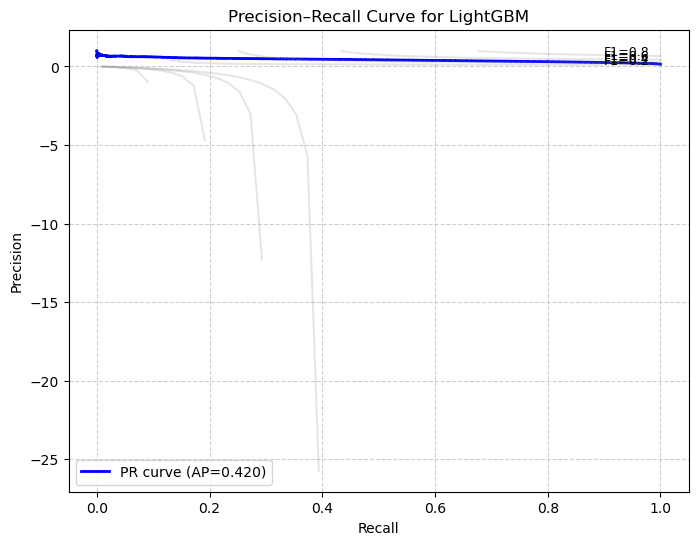

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Use your LightGBM best pipeline or model
# If you used the unified pipeline approach:
pipe = best_pipelines[("LightGBM", "None")]  # or whichever sampler performed best
y_score = pipe.predict_proba(X_test)[:, 1]

# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
avg_prec = average_precision_score(y_test, y_score)

# Plot PR curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AP={avg_prec:.3f})")

# Plot F1 iso-lines for visual reference
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = (f_score * x) / (2 * x - f_score)
    y[y > 1] = np.nan
    plt.plot(x, y, color="gray", alpha=0.2)
    plt.text(0.9, (f_score * 0.9) / (2 * 0.9 - f_score), f"F1={f_score:.1f}", fontsize=9)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for LightGBM")
plt.legend(loc="lower left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [22]:
# Part 8: LightGBM — imbalance fixes + threshold tuning (val-based)
import numpy as np
import pandas as pd
import json
import time
import os
from pprint import pprint

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)

import lightgbm as lgb
import matplotlib.pyplot as plt

# ---------- helpers ----------
def compute_metrics(y_true, proba, threshold=0.5, prefix=""):
    preds = (proba >= threshold).astype(int)
    out = {
        f"{prefix}threshold": float(threshold),
        f"{prefix}accuracy": accuracy_score(y_true, preds),
        f"{prefix}precision": precision_score(y_true, preds, zero_division=0),
        f"{prefix}recall": recall_score(y_true, preds, zero_division=0),
        f"{prefix}f1": f1_score(y_true, preds, zero_division=0),
        f"{prefix}roc_auc": roc_auc_score(y_true, proba),
        f"{prefix}pr_auc": average_precision_score(y_true, proba),
        f"{prefix}positive_rate_pred": float(preds.mean()),
    }
    return out

def tune_threshold_for_f1(y_true, proba, grid=None):
    if grid is None:
        # try a dense grid in the range that usually helps for ~10–20% positives
        grid = np.linspace(0.05, 0.5, 46)  # 0.05, 0.06, ..., 0.50
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        f1 = f1_score(y_true, (proba >= t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    return best_t, best_f1

def plot_curves(y_true, proba, name_prefix):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, proba):.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(f"ROC — {name_prefix}")
    plt.legend(loc="lower right")
    roc_path = os.path.join(OUTPUT_DIR, f"{name_prefix}_ROC.png")
    plt.savefig(roc_path, bbox_inches="tight"); plt.close()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, proba)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={average_precision_score(y_true, proba):.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall — {name_prefix}")
    plt.legend(loc="lower left")
    pr_path = os.path.join(OUTPUT_DIR, f"{name_prefix}_PR.png")
    plt.savefig(pr_path, bbox_inches="tight"); plt.close()
    return {"roc_plot": roc_path, "pr_plot": pr_path}

# ---------- small param sweep ----------
param_grid = []
for w in [4.0, 5.0, 6.0, 7.0, 8.0]:       # imbalance strength
    for lr in [0.02, 0.03]:               # learn slower, train longer
        param_grid.append({
            "scale_pos_weight": w,
            "learning_rate": lr,
            "num_leaves": 31,
            "max_depth": 7,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "reg_alpha": 0.1,
            "reg_lambda": 0.1,
            "n_estimators": 5000,
            "boosting_type": "gbdt",
            "random_state": RANDOM_STATE,
            "n_jobs": 1
        })

val_results = []
best_record = None

print(f"[INFO] Param combos: {len(param_grid)}")
for i, p in enumerate(param_grid, 1):
    print(f"\n=== Fit {i}/{len(param_grid)}: {p} ===")
    clf = lgb.LGBMClassifier(**p)
    start = time.time()
    clf.fit(
        X_train_proc, y_train,
        eval_set=[(X_val_proc, y_val)],
        eval_metric=["auc", "average_precision"],
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    train_time = time.time() - start

    # Validation probabilities
    val_proba = clf.predict_proba(X_val_proc)[:, 1]

    # Metrics at default 0.5
    val_metrics_05 = compute_metrics(y_val, val_proba, threshold=0.5, prefix="val@0.5_")

    # Tune threshold for F1 on validation
    best_t, best_f1 = tune_threshold_for_f1(y_val, val_proba)
    val_metrics_best = compute_metrics(y_val, val_proba, threshold=best_t, prefix="val@best_")

    # Keep record
    record = {
        "params": p,
        "best_iteration": int(getattr(clf, "best_iteration_", p["n_estimators"]) or p["n_estimators"]),
        "train_time_sec": round(train_time, 3),
        **val_metrics_05,
        **val_metrics_best,
        "val_best_threshold": best_t
    }
    val_results.append(record)

    # Track best by F1 on validation (tie-break by PR-AUC)
    if (best_record is None) or \
       (record["val@best_f1"] > best_record["val@best_f1"]) or \
       (np.isclose(record["val@best_f1"], best_record["val@best_f1"]) and
        record["val@best_pr_auc"] > best_record["val@best_pr_auc"]):
        best_record = record
        best_model = clf

print("\n[SUMMARY] Validation sweep (top 5 by F1):")
df_val = pd.DataFrame(val_results).sort_values("val@best_f1", ascending=False)
display(df_val.head(5))

# Save sweep table
val_csv = os.path.join(OUTPUT_DIR, "lgbm_val_sweep.csv")
df_val.to_csv(val_csv, index=False)
print("Saved:", val_csv)

print("\n[WINNER] Best validation config:")
pprint({k: best_record[k] for k in [
    "val@best_f1","val@best_precision","val@best_recall","val@best_pr_auc","val@best_roc_auc","val_best_threshold",
    "val@0.5_f1","val@0.5_precision","val@0.5_recall","val@0.5_pr_auc","best_iteration","train_time_sec"
]})
print("\nBest params:")
pprint(best_record["params"])

# Plots on validation for the best model
val_plots = plot_curves(y_val, best_model.predict_proba(X_val_proc)[:,1], "LightGBM_val_best")
print("Validation plots saved:", val_plots)


[INFO] Param combos: 10

=== Fit 1/10: {'scale_pos_weight': 4.0, 'learning_rate': 0.02, 'num_leaves': 31, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'n_estimators': 5000, 'boosting_type': 'gbdt', 'random_state': 42, 'n_jobs': 1} ===


NameError: name 'X_train_proc' is not defined

In [ ]:
# Part 10: Inspect best per model by test F1 and show top importances for tree boosters
best_rows = results_df.sort_values("test_f1", ascending=False).groupby("model", as_index=False).first()
display(best_rows[["model","sampler","thr_val_best_f1","test_f1","test_precision","test_recall","test_pr_auc","test_roc_auc"]])

def show_top_importances(model_name, sampler_name, top_k=15):
    pipe = best_pipelines[(model_name, sampler_name)]
    clf = pipe.named_steps["clf"]
    # Get feature names post-preprocessing
    feat_names_num = [f"num__{c}" for c in numeric_cols]
    feat_names_bin = binary_cols[:]  # passthrough keeps original names
    feature_names = feat_names_num + feat_names_bin

    importances = None
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        # Logistic regression (absolute coefficients)
        coef = np.ravel(clf.coef_)
        importances = np.abs(coef)
    else:
        print(f"No importances available for {model_name}.")
        return

    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(top_k)
    display(imp_df)

# Example: show importances for your best LightGBM variant if it appears in best_rows
for _, row in best_rows.iterrows():
    if row["model"] in ["LightGBM","RandomForest","XGBoost","LogisticRegression"]:
        print(f"\nTop features for {row['model']} ({row['sampler']}):")
        show_top_importances(row["model"], row["sampler"], top_k=15)
